In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import time
import mlflow

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB

# Constantes
PATH_TO_ROOT = "../../"
PATH_DATA = PATH_TO_ROOT + "data/"
PATH_RAW = PATH_DATA + "raw/"
PATH_PROCESSED = PATH_DATA + "processed/"
PATH_EXTERNAL = PATH_DATA + "external/"
SEED = 123

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)

def change_format_hour(total_seconds):
    """Function to convert total seconds into hours, minutes and seconds format.
    Args:
        total_seconds (int): Total number of seconds to convert.
        
    Returns:
        None, but prints the formatted runtime in the following format: HH:MM:SS
    """
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    print(f"Total runtime: {hours:02d}:{minutes:02d}:{seconds:02d}s")


# Chargement des données

In [9]:
df = pd.read_csv(PATH_PROCESSED + "X_train_preprocessed.csv", index_col=0)
# df = pd.read_csv(PATH_PROCESSED + "X_train_detected_language.csv", index_col=0)
# df_target = pd.read_csv(PATH_RAW + "y_train.csv", index_col=0)
# df[df_target.columns[0]] = df_target
display(df.head())
display(df.describe())
display(df.info())

stop_words_french = pd.read_json(PATH_EXTERNAL + "stop_words_french.json")
print(stop_words_french.shape)
stop_words = []
stop_words.extend(stop_words_french[0].tolist())
stop_words.extend(["cm", "mm"])
print(len(stop_words))
stop_words[:10]

,productid,imageid,text,lemmes,len_text,len_lemmes,prdtypecode
0,3804725264,1263597046,pages de carnet personnalisées olivia dot grid...,page de carnet personnalisé olivia dot grid ca...,68,64,10
1,436067568,1008141237,journal des arts le n du l art et son marche s...,journal des art le ne du l art et son marche s...,177,172,2280
2,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,grand stylet ergonomique bleu gamepad nintendo...,731,732,50
3,50418756,457047496,peluche donald europe disneyland marionnette à...,peluche donald europe disneyland marionnette à...,52,52,1280
4,278535884,1077757786,la guerre des tuques luc a des idées de grande...,la guerre des tuques luc a des idée de grandeu...,203,212,2705


,productid,imageid,len_text,len_lemmes,prdtypecode
count,8.491600e+04,8.491600e+04,84916.000000,84916.000000,84916.000000
mean,2.555468e+09,1.152691e+09,520.531537,517.319422,1773.219900
std,1.588656e+09,1.751427e+08,664.802838,660.806625,788.179885
min,1.839120e+05,6.728400e+04,4.000000,4.000000,10.000000
25%,6.760519e+08,1.056269e+09,57.000000,56.000000,1281.000000
50%,3.190506e+09,1.213354e+09,265.000000,263.000000,1920.000000
75%,3.995599e+09,1.275646e+09,806.000000,803.000000,2522.000000
max,4.252012e+09,1.328824e+09,11919.000000,12066.000000,2905.000000


<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productid    84916 non-null  int64 
 1   imageid      84916 non-null  int64 
 2   text         84916 non-null  object
 3   lemmes       84916 non-null  object
 4   len_text     84916 non-null  int64 
 5   len_lemmes   84916 non-null  int64 
 6   prdtypecode  84916 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.2+ MB


None

(496, 1)
498


['a', 'à', 'â', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi', 'allaient']

In [10]:
value_counts = df["prdtypecode"].value_counts()
median = int(value_counts.median())
print("median :", median)
value_counts_index = value_counts[value_counts > median].index
print(value_counts_index)

median : 2671
Index([2583, 1560, 1300, 2060, 2522, 1280, 2403, 2280, 1920, 1160, 1320, 10,
       2705],
      dtype='int64', name='prdtypecode')


In [11]:
to_split = True

index_row = []
if to_split:
    for i in value_counts.index:
        if i in value_counts_index:
            index_row.extend(
                df.loc[df["prdtypecode"] == i].sample(n=median, random_state=123).index
            )
        else:
            index_row.extend(df.loc[df["prdtypecode"] == i].index)
else:
    index_row.extend(df.index)

data = df.loc[df.index.isin(index_row)]["text"]
target = df.loc[df.index.isin(index_row)]["prdtypecode"].astype("int")
print(data.shape)
print(target.shape)

(57552,)
(57552,)


# TfidfVectorizer

Voici les paramètres qui me semblent importants pour une classification de texte sur un corpus de 90 000 textes d'environ 500 caractères chacun:

- Le paramètre <b>ngram_range</b>, qui permet de générer des n-grams de caractères ou de mots. Pour un texte court, les unigrams et bigrams seraient probablement suffisants. 

- Le paramètre <b>max_features</b>, qui limite le nombre de features conservées. Étant donné le grand nombre de textes, il serait sage de limiter le nombre de features pour éviter le surapprentissage. 

- Le paramètre <b>min_df</b>, qui ignore les mots apparaissant dans trop peu de documents. Ici, on peut ignorer les mots n'apparaissant que dans quelques dizaines de textes sur 90 000.

- Le paramètre <b>max_df</b>, qui ignore les mots trop fréquents comme les mots vides. Avec des textes courts, de nombreux mots apparaitront dans une grande proportion des textes.

- Le paramètre <b>stop_words</b>, pour retirer les mots vides de la langue du corpus.

- Le paramètre <b>lowercase</b>, pour mettre tous les mots en minuscules et ainsi neutraliser les variations casse.

Voilà les principaux paramètres à prendre en compte pour cette tâche de classification de texte sur un grand corpus de textes courts.

In [12]:
tfidf_vect = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.5,
    min_df=0.00001,
    lowercase=True,
    stop_words=stop_words,
    max_features=350000,
)
start_time = time.time()

data_vec = tfidf_vect.fit_transform(data)

end_time = time.time()

change_format_hour(end_time - start_time)

# Split data into training and testing sets
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    data_vec, target, test_size=0.2, random_state=SEED
)

print("X_train shape :", X_train_vec.shape)
print("X_test shape  :", X_test_vec.shape)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


Total runtime: 00:00:01s
X_train shape : (46041, 111531)
X_test shape  : (11511, 111531)


# SMOTE

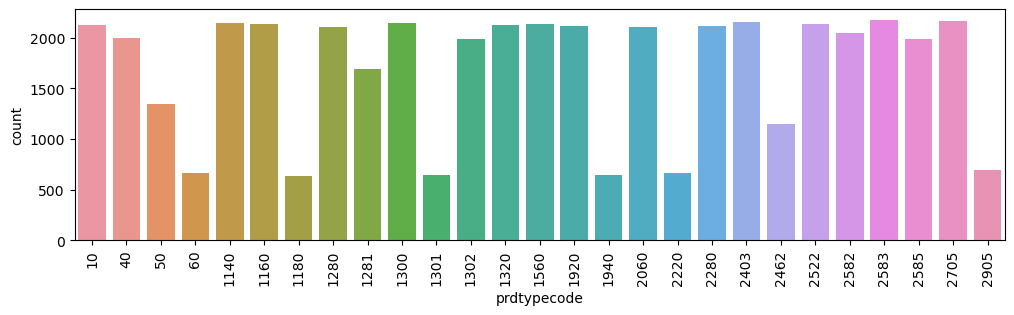

Total runtime: 00:00:11s


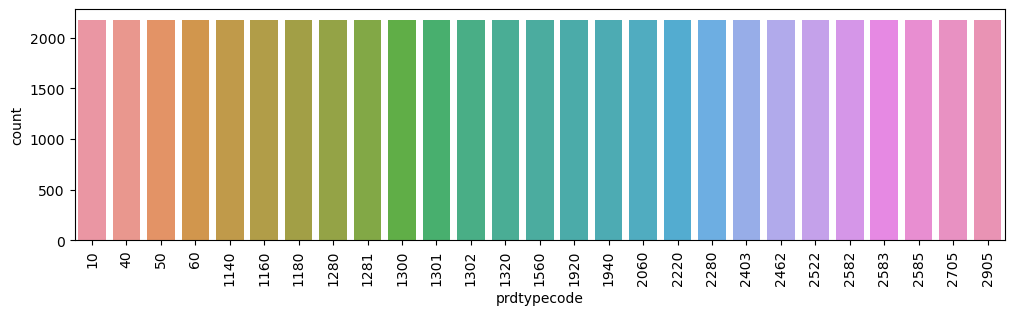

X_train shape : (58698, 111531)
X_test shape  : (11511, 111531)


In [13]:
count = y_train.value_counts().to_frame()
plt.figure(figsize=(12, 3))
sns.barplot(count, x=count.index, y="count")
plt.xticks(rotation=90)
plt.show()

start_time = time.time()

smote = SMOTE(random_state=SEED)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
end_time = time.time()

change_format_hour(end_time - start_time)

count = y_train.value_counts().to_frame()
plt.figure(figsize=(12, 3))
sns.barplot(count, x=count.index, y="count")
plt.xticks(rotation=90)
plt.show()
print("X_train shape :", X_train_vec.shape)
print("X_test shape  :", X_test_vec.shape)

if X_train_vec.shape[0] * X_train_vec.shape[1] < 100000000:
    X_train_dense = X_train_vec.toarray()
    unique_rows, counts = np.unique(X_train_dense, axis=0, return_counts=True)
    duplicate_rows = unique_rows[counts > 1]

    if len(duplicate_rows) > 0:
        print(f"Found {len(duplicate_rows)} duplicate rows in the matrix.")
    else:
        print("No duplicate rows found in the matrix.")

# Naive Bayes
D'après la page, les modèles de classification naïve bayésienne sont souvent bien adaptés aux données de classification de texte, car ils nécessitent peu de données d'entraînement et sont très rapides par rapport à d'autres méthodes plus sophistiquées. 

En particulier, le modèle "Multinomial Naive Bayes" est l'un des deux modèles naïfs bayésiens classiques utilisés pour la classification de texte, car il suppose une distribution multinomiale des données, ce qui convient bien aux vecteurs de comptage de mots qui représentent généralement les données textuelles. 

Le modèle "Complement Naive Bayes" est également mentionné comme s'adaptant particulièrement bien aux ensembles de données déséquilibrés, en utilisant des statistiques du "complément" de chaque classe pour calculer les poids du modèle.

Donc en résumé, les modèles de classification naïve bayésienne comme "Multinomial Naive Bayes" et "Complement Naive Bayes" sont souvent les mieux adaptés pour la classification de texte avec des entrées textuelles et une cible de classification.

#### Peu importe le nombre de `max_features`, le résultat est instantané

## MultinomialNB

In [14]:
mlflow.set_tracking_uri("../../mlruns")
mlflow.set_experiment("Naive Bayes")
mlflow.sklearn.autolog(log_datasets=False)

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1313, in _read_helper
    result = read_yaml(root, file_name)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 310, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file '../../mlruns/3826220

In [17]:
# Define parameters to search over
params = {
    "alpha": [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "fit_prior": [True, False],
}

# Create a GridSearchCV object with the desired estimator and parameter grid
grid_search_mnb = GridSearchCV(MultinomialNB(), params, scoring="f1_weighted")

start_time = time.time()

with mlflow.start_run() as run:
    print("Run id:", run.info.run_id)
    # Fit the model to the data
    grid_search_mnb.fit(X_train_vec, y_train)

end_time = time.time()
change_format_hour(end_time - start_time)

best_params_mnb = grid_search_mnb.best_params_

print(best_params_mnb)
print(grid_search_mnb.best_score_)

Run id: 3cc7c2da8a064176a5622aa978ca3d65


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2024/05/02 20:09:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 17 runs will be omitted.


Total runtime: 00:00:11s
{'alpha': 0.001, 'fit_prior': False}
0.7965837622013067


In [7]:
clf_mnb = MultinomialNB(
    alpha=best_params_mnb["alpha"], fit_prior=best_params_mnb["fit_prior"]
)

start_time = time.time()

clf_mnb.fit(X_train_vec, y_train)

end_time = time.time()
change_format_hour(end_time - start_time)

print("Score train :", clf_mnb.score(X_train_vec, y_train))
print("Score test :", clf_mnb.score(X_test_vec, y_test))

y_pred = clf_mnb.predict(X_test_vec)

f1_train = metrics.f1_score(y_train, clf_mnb.predict(X_train_vec), average="weighted")
f1_test = metrics.f1_score(y_test, y_pred, average="weighted")

print("F1 score train :", f1_train.round(3))
print("F1 score test :", f1_test.round(3))

Total runtime: 00:00:00s
Score train : 0.9058882300558199
Score test : 0.7450264963947528
F1 score train : 0.906
F1 score test : 0.738


## ComplementNB

In [8]:
# Define parameters to search over
params = {
    "alpha": [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "fit_prior": [True, False],
}

# Create a GridSearchCV object with the desired estimator and parameter grid
grid_search_cnb = GridSearchCV(ComplementNB(), params)

start_time = time.time()

# Fit the model to the data
grid_search_cnb.fit(X_train_vec, y_train)

end_time = time.time()
change_format_hour(end_time - start_time)

best_params_cnb = grid_search_cnb.best_params_

print(best_params_cnb)
print(grid_search_cnb.best_score_)

Total runtime: 00:00:06s
{'alpha': 0.9, 'fit_prior': True}
0.7217915150998263


In [9]:
clf_cnb = ComplementNB(
    alpha=best_params_cnb["alpha"], fit_prior=best_params_cnb["fit_prior"]
)

start_time = time.time()

clf_cnb.fit(X_train_vec, y_train)

end_time = time.time()
change_format_hour(end_time - start_time)

print("Score train :", clf_cnb.score(X_train_vec, y_train))
print("Score test :", clf_cnb.score(X_test_vec, y_test))

y_pred = clf_cnb.predict(X_test_vec)

f1_train = metrics.f1_score(y_train, clf_cnb.predict(X_train_vec), average="weighted")
f1_test = metrics.f1_score(y_test, y_pred, average="weighted")

print("F1 score train :", f1_train.round(3))
print("F1 score test :", f1_test.round(3))

Total runtime: 00:00:00s
Score train : 0.8611020612063162
Score test : 0.7249587351229259
F1 score train : 0.859
F1 score test : 0.711


## GaussianNB

In [11]:
clf_gnb = GaussianNB()

start_time = time.time()

X_train_vec_dense = X_train_vec.toarray()

clf_gnb.fit(X_train_vec_dense, y_train)

end_time = time.time()
change_format_hour(end_time - start_time)

print("Score train :", clf_gnb.score(X_train_vec_dense, y_train))
print("Score test :", clf_gnb.score(X_test_vec, y_test))

y_pred = clf_gnb.predict(X_test_vec)

f1_train = metrics.f1_score(
    y_train, clf_gnb.predict(X_train_vec_dense), average="weighted"
)
f1_test = metrics.f1_score(y_test, y_pred, average="weighted")

print("F1 score train :", f1_train.round(3))
print("F1 score test :", f1_test.round(3))

: 

# Best params
## MultinomialNB
### Params 1
- F1 score (train) : 0.957
- F1 score (test)  : 0.76

avec SMOTE

X_train shape : (220428, 130770)

X_test shape  : (16984, 130770)

{'alpha': 0.001, 'fit_prior': False}

### Params 2
- F1 score (train) : 0.899
- F1 score (test)  : 0.772

sans SMOTE

X_train shape : (67932, 130770)

X_test shape  : (16984, 130770)

{'alpha': 0.1, 'fit_prior': False}

## ComplementNB
Sans SMOTE

X_train shape : (67932, 130770)

X_test shape  : (16984, 130770)

{'alpha': 0.5, 'fit_prior': True}